In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

In [5]:
dataset_dir = Path('../datasets_secret')
templates_raw = pd.read_csv(dataset_dir / 'templates_w_nodes.csv')


# convert content to json
templates_raw['content_dict'] = templates_raw['content'].apply(json.loads)

templates_raw.head()

templates_raw.columns



Index(['prompt', 'used', 'createdAt', 'url', 'width', 'height', 'templateId',
       'presetConfigSlug', 'seed', 'negativePrompt', 'prompt_embedding',
       'url_jpeg', 'image_embedding', 'content', 'previewUrl',
       'promptSuggestions', 'id', 'title', 'used.1', 'userId', 'createdAt.1',
       'updatedAt', 'visibility', 'keywords', 'type', 'visibilityUpdatedAt',
       'visibilityUpdatedBy', 'source', 'content_dict'],
      dtype='object')

In [6]:
any_text_filter = lambda x: any(node['type'] == 'text' for node in x['nodes'])
any_image_filter = lambda x: any(node['type'] == 'image' for node in x['nodes'])
not_any_geo_filter = lambda x: not any(node['type'] == 'geo' for node in x['nodes'])

# Filter for templates with just images and text, and NEVER geo
templates_images_and_text = templates_raw[
    (templates_raw['content_dict'].apply(any_text_filter)
    | templates_raw['content_dict'].apply(any_image_filter))
    &
    templates_raw['content_dict'].apply(not_any_geo_filter)
]
num_templates = len(templates_images_and_text)
print(f"Number of templates: {num_templates}")

# Print a random template
random_template = templates_images_and_text.iloc[np.random.randint(0, num_templates)]
print(random_template.content)


Number of templates: 1322
{"nodes": [{"x": 221.7550073792955, "y": 816.360952983344, "id": "shape:anN79LErbQC3uvhxdrfcW", "fill": "#3C3C3C", "font": "'Alegreya', 'Alegreya Fallback'", "text": "“Growth takes time — like the sun rising, little by little.”", "type": "text", "angle": 0, "scale": 1.451224963103522, "width": 400, "height": 100, "opacity": 1, "fontSize": 64, "richText": {"type": "doc", "content": [{"type": "paragraph", "attrs": {"dir": "auto"}, "content": [{"text": "“Growth takes time — like the sun rising, little by little.”", "type": "text", "marks": [{"type": "textStyle", "attrs": {"color": "#3C3C3C", "fontSize": null}}]}]}]}, "fontStyle": "normal", "textAlign": "center", "fontWeight": "400", "lineHeight": 1, "letterSpacing": 0, "textDecoration": "none"}, {"x": 214.8462998102466, "y": 173.6925996204929, "id": "shape:fWFo7ioeoTvAZC42w6mM3", "url": "https://images.playground.com/f4675ec3-d206-4fcf-8836-0bad032567fb.png", "crop": null, "meta": {"model": "4o", "source": "ai-ge

Evaluating UI quality scores...
Scoring 1131w-02GXIIidf_4...
Scoring 1131w-50t2MzJLmsM...
Scoring 1131w-9cN5biKALLQ...
Scoring 1131w-Cn6h5Tqrn10...
Scoring 1131w-DBVzDPV0y5E...
Scoring 1131w-HeJuVR7Avb0...
Scoring 1131w-MQeKlmQ9RXc...
Scoring 1131w-Uq1C4aZZi9w...
Scoring 1131w-eRlpDg4f0K8...
Scoring 1131w-rH9o0IzDWQY...
Scoring 1131w-sSnAV2dB_qg...
Scoring 1131w-w-XME4y3KWk...
Scoring 1131w-zau150HLMWk...
Scoring 1131w-zsrhBwj_J58...
Scoring 1143w-ugSBoa9VtEw...
Scoring 1200w-taPfkpk_5cE...
Scoring 1257w-EN_LTZdAMlw...
Scoring 1257w-dnPJ18q1Q2E...
Scoring 1280w-1EsFpGQoTQo...
Scoring 1280w-7NdToF9SL00...
Scoring 1280w-GZEFZIEhLE0...
Scoring 1280w-IBJtTP4icf8...
Scoring 1280w-QVxrpF_dKgM...
Scoring 1600w-1HZYAUid2AE...
Scoring 1600w-3BBdsD4EXsY...
Scoring 1600w-4gpfnsQOREQ...
Scoring 1600w-7YZFYlcCTPk...
Scoring 1600w-9JTrLkx-Ppg...
Scoring 1600w-9eXC-dXI0uE...
Scoring 1600w-A9ARWpzo3xk...
Scoring 1600w-CxALar1xspQ...
Scoring 1600w-D3Vl-1x6STM...
Scoring 1600w-DB7VCKEjrvU...
Scoring 160

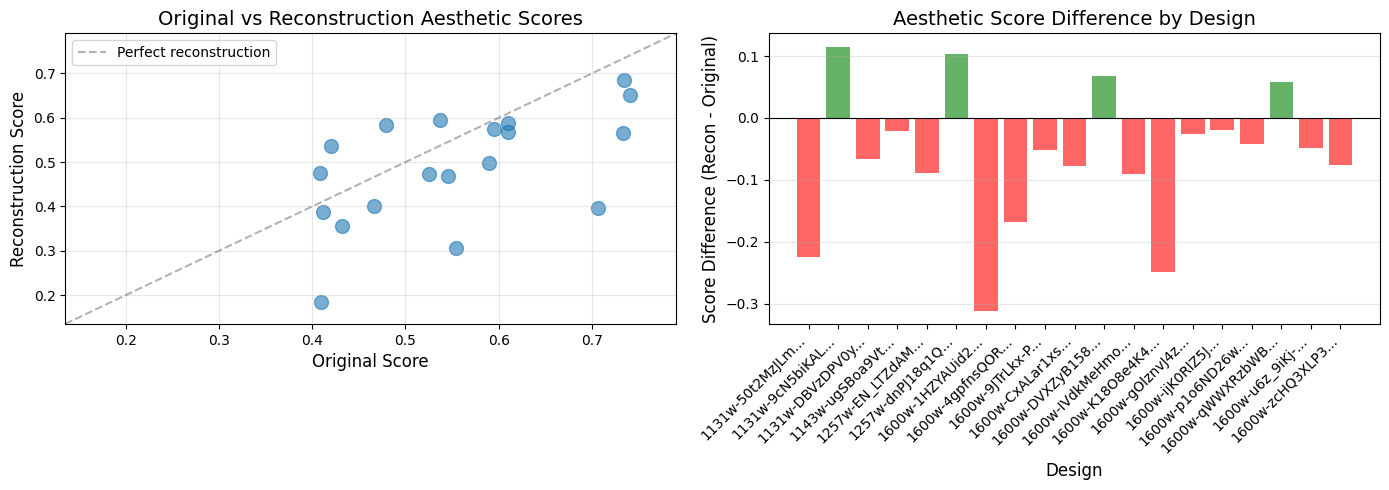


SUMMARY STATISTICS
Average Original Score:        0.5532
Average Reconstruction Score:  0.4894
Average Difference:            -0.0639

Best Reconstruction:  1600w-u6z_9iKj-iQ
  Score: 0.6857

Worst Reconstruction: 1131w-50t2MzJLmsM
  Score: 0.1852


In [7]:
# Evaluate UI quality scores for originals and reconstructions
import sys
sys.path.append('..')
from lib.uiclip import score_image
import matplotlib.pyplot as plt

canva_dir = Path('../datasets/canva')
reconstructions_dir = Path('../datasets/reconstructions')

print("Evaluating UI quality scores...")

# Get all original Canva images
canva_images = sorted(canva_dir.glob('*.webp'))

results = []

for img_path in canva_images:
    design_name = img_path.stem
    
    print(f"Scoring {design_name}...")
    
    # Score original
    original_score = score_image(img_path, description="graphic design")
    
    # Score reconstruction if it exists
    reconstruction_path = reconstructions_dir / design_name / "render.png"
    if reconstruction_path.exists():
        reconstruction_score = score_image(reconstruction_path, description="graphic design")
        
        results.append({
            'name': design_name,
            'original': original_score,
            'reconstruction': reconstruction_score,
            'diff': reconstruction_score - original_score
        })

# Convert to DataFrame
df_scores = pd.DataFrame(results)
print(f"\n{df_scores}")

# Plot comparison
if len(df_scores) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: Original vs Reconstruction
    ax1 = axes[0]
    ax1.scatter(df_scores['original'], df_scores['reconstruction'], s=100, alpha=0.6)
    
    # Add diagonal line (perfect reconstruction)
    lims = [
        min(df_scores['original'].min(), df_scores['reconstruction'].min()) - 0.05,
        max(df_scores['original'].max(), df_scores['reconstruction'].max()) + 0.05,
    ]
    ax1.plot(lims, lims, 'k--', alpha=0.3, label='Perfect reconstruction')
    
    ax1.set_xlabel('Original Score', fontsize=12)
    ax1.set_ylabel('Reconstruction Score', fontsize=12)
    ax1.set_title('Original vs Reconstruction Aesthetic Scores', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    # Bar plot: Difference by design
    ax2 = axes[1]
    colors = ['green' if d >= 0 else 'red' for d in df_scores['diff']]
    ax2.bar(range(len(df_scores)), df_scores['diff'], color=colors, alpha=0.6)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    ax2.set_xlabel('Design', fontsize=12)
    ax2.set_ylabel('Score Difference (Recon - Original)', fontsize=12)
    ax2.set_title('Aesthetic Score Difference by Design', fontsize=14)
    ax2.set_xticks(range(len(df_scores)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_scores['name']], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Average Original Score:        {df_scores['original'].mean():.4f}")
    print(f"Average Reconstruction Score:  {df_scores['reconstruction'].mean():.4f}")
    print(f"Average Difference:            {df_scores['diff'].mean():+.4f}")
    print(f"\nBest Reconstruction:  {df_scores.loc[df_scores['reconstruction'].idxmax(), 'name']}")
    print(f"  Score: {df_scores['reconstruction'].max():.4f}")
    print(f"\nWorst Reconstruction: {df_scores.loc[df_scores['reconstruction'].idxmin(), 'name']}")
    print(f"  Score: {df_scores['reconstruction'].min():.4f}")


In [ ]:
# Evaluate aesthetic scores using Gemini
from lib.ai import gemini_score_aesthetic

canva_dir = Path('../datasets/canva')
reconstructions_dir = Path('../datasets/reconstructions')

print("Evaluating aesthetic scores with Gemini...")

# Get all original Canva images
canva_images = sorted(canva_dir.glob('*.webp'))

results_gemini = []

for img_path in canva_images:
    design_name = img_path.stem
    
    print(f"Scoring {design_name}...")
    
    # Score original
    original_score = gemini_score_aesthetic(img_path)
    
    # Score reconstruction if it exists
    reconstruction_path = reconstructions_dir / design_name / "render.png"
    if reconstruction_path.exists():
        reconstruction_score = gemini_score_aesthetic(reconstruction_path)
        
        results_gemini.append({
            'name': design_name,
            'original': original_score,
            'reconstruction': reconstruction_score,
            'diff': reconstruction_score - original_score
        })

# Convert to DataFrame
df_gemini = pd.DataFrame(results_gemini)
print(f"\n{df_gemini}")

# Plot comparison
if len(df_gemini) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: Original vs Reconstruction
    ax1 = axes[0]
    ax1.scatter(df_gemini['original'], df_gemini['reconstruction'], s=100, alpha=0.6, color='purple')
    
    # Add diagonal line (perfect reconstruction)
    lims = [
        min(df_gemini['original'].min(), df_gemini['reconstruction'].min()) - 5,
        max(df_gemini['original'].max(), df_gemini['reconstruction'].max()) + 5,
    ]
    ax1.plot(lims, lims, 'k--', alpha=0.3, label='Perfect reconstruction')
    
    ax1.set_xlabel('Original Score (0-100)', fontsize=12)
    ax1.set_ylabel('Reconstruction Score (0-100)', fontsize=12)
    ax1.set_title('Gemini: Original vs Reconstruction Aesthetic Scores', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    # Bar plot: Difference by design
    ax2 = axes[1]
    colors = ['green' if d >= 0 else 'red' for d in df_gemini['diff']]
    ax2.bar(range(len(df_gemini)), df_gemini['diff'], color=colors, alpha=0.6)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    ax2.set_xlabel('Design', fontsize=12)
    ax2.set_ylabel('Score Difference (Recon - Original)', fontsize=12)
    ax2.set_title('Gemini: Aesthetic Score Difference by Design', fontsize=14)
    ax2.set_xticks(range(len(df_gemini)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_gemini['name']], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print("\n" + "="*60)
    print("GEMINI SUMMARY STATISTICS")
    print("="*60)
    print(f"Average Original Score:        {df_gemini['original'].mean():.2f}")
    print(f"Average Reconstruction Score:  {df_gemini['reconstruction'].mean():.2f}")
    print(f"Average Difference:            {df_gemini['diff'].mean():+.2f}")
    print(f"\nBest Reconstruction:  {df_gemini.loc[df_gemini['reconstruction'].idxmax(), 'name']}")
    print(f"  Score: {df_gemini['reconstruction'].max():.2f}")
    print(f"\nWorst Reconstruction: {df_gemini.loc[df_gemini['reconstruction'].idxmin(), 'name']}")
    print(f"  Score: {df_gemini['reconstruction'].min():.2f}")
